# Smoothing Results

This notebook is an analysis piece to ensure that even though the tuned smoothing parameter may improve the overall AUC, it is not disproportionately effecting a given minutes AUC. For example, improving performance early on, but worsening performance for later predictions.

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
import starcraft_predictor as scp  # noqa: E402

In [2]:
EWM_ALPHA_LIST = [0.1,0.3, 0.5, 0.7]

def load_data(path: str) -> pd.DataFrame:
    """Load the data and subset to just test data"""

    data = pd.read_csv(path)
    data = data[data["sample"] == "test"]

    return data


def generate_smoothed_predictions(data: pd.DataFrame, alpha: float) -> np.ndarray:
    """Generate smoothed predictions for a given alpha"""

    predictions = scp.starcraft_model.predict(data, smoothed=False)
    smoothed_predictions = np.array(
        pd.Series(predictions).ewm(alpha=alpha).mean()
    )

    return smoothed_predictions


def generate_predictions_df(data: pd.DataFrame) -> dict:
    """Generate base predictions and smoothed predictions"""

    df = pd.DataFrame({"seconds": data["seconds"], "winner": data["winner"]})

    df["base_predictions"] = scp.starcraft_model.predict(
        data, smoothed=False,
    )

    for alpha in EWM_ALPHA_LIST:
        smoothed_predictions = generate_smoothed_predictions(
            data=data, alpha=alpha,
        )

        df[f"alpha={alpha}"] = smoothed_predictions

    return df


def create_auc_df(prediction_df):
    
    aucs = {}
    for col in prediction_df.columns[2:]:
        aucs[col] = []
    
    for i in range(20):
        lower_bound = i*60
        upper_bound = (i+1)*60
        
        data_subset = prediction_df[
            (prediction_df["seconds"] >= lower_bound) & (prediction_df["seconds"] < upper_bound)
        ]
        
        for i in data_subset.columns[2:]:
            aucs[i].append(roc_auc_score(data_subset["winner"], data_subset[i]))
        
    return pd.DataFrame(aucs, index=range(1, 21))


def plot_aucs(auc_df):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.lineplot(data=auc_df, markers=True, dashes=False)
    plt.xlabel("Game Minutes")
    plt.ylabel("AUC")
    plt.title("AUC by Game Minute, varying by Smoothing Parameter")
    plt.legend(title="smoothing parameter")
    plt.show()
    plt.tight_layout()

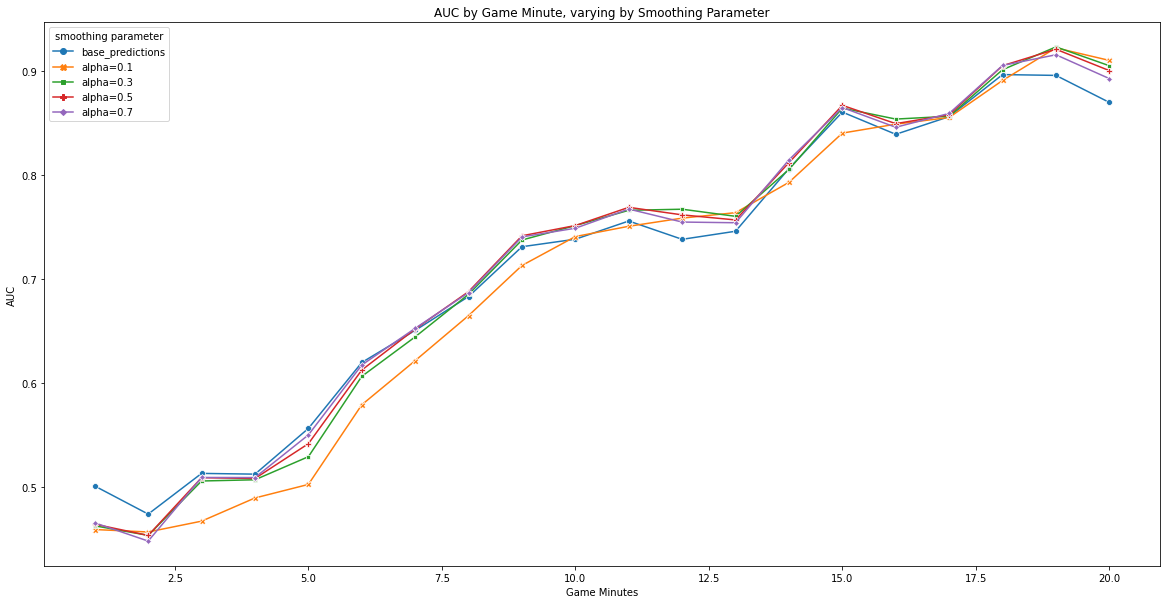

<Figure size 432x288 with 0 Axes>

In [3]:
path = "C:/Users/Edward/Documents/python_project/sc2_data/transformed_data.csv"
data = load_data(path)

prediction_df = generate_predictions_df(data)

auc_df = create_auc_df(prediction_df)

plot_aucs(auc_df)

It appears that the smoothed predictions perform worse during the early stages of the game, but improve as the game continues. A judgement call is being made here to accept the optimised alpha value `alpha=0.5` as the final smoothing factor.